# Explorative Datenanalyse

### Import der benötigten Pakete

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
from wordcloud import WordCloud, STOPWORDS
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

### Einlesen der CSV-Dateien

In [17]:
# Funktion zum Einlesen
def csv_to_df(csv):
    df = pd.read_csv(csv, header=0, sep=';', quotechar='"', decimal=',', low_memory=False)
    return df

# Produkte
product = csv_to_df("../data/origin/PRODUCT.csv")
product.name = "Produkte"

# Hersteller
company = csv_to_df("../data/origin/COMPANY.csv")
company.name = "Hersteller"

# Hersteller-Adresse
company_adress = csv_to_df("../data/origin/COMPANYADDRESS.csv")
company_adress.name = "Hersteller-Adresse"

# Schnittstelle Hersteller u. Produkt
product_company = csv_to_df("../data/origin/PRODUCT_COMPANY.csv")
product_company.name = "API-Produkt-Hersteller"

# Interaktionen
interaction = csv_to_df("../data/origin/INTERACTION.CSV")
interaction.name = "Interaktionen"

# Interaktions-Klasse
interaction_class = csv_to_df("../data/origin/INTERACTION_CLASS.csv")
interaction_class.name = "Interaktionsklasse"

# Schnittstelle zw. Produkte u. Interaktionen
product_interaction_class = csv_to_df("../data/origin/PRODUCT_INTERACTION_CLASS.csv")
product_interaction_class.name = "API-Produkte-Interaktionen"

### Bereinigung der Dataframes auf die relevanten Spalten

In [12]:
# Produkte (hier reicht die ID, der Name und als zusätzl. Info das Markteintrittsdatum)
product = product[['ID','NAME','ONMARKETDATE']]

# Hersteller (ID, Name)
company = company[['ID','NAME']]

# Hersteller-Adresse (ID, COMPANYID, ZIP, STREET, STREETNUMBER)
company_adress = company_adress[['ID', 'COMPANYID', 'ZIP', 'CITY', 'STREET', 'STREETNUMBER']]

# Schnittstelle zw. Produkte und Hersteller
product_company = product_company[['PRODUCTID', 'COMPANYID']]

# Interaktionen (ID, Interaktionsklasse1, Interaktionsklasse2, Severity, Likelihood)
interaction = interaction[['INTERACTIONCLASSID1', 'INTERACTIONCLASSID2', 'SEVERITY', 'LIKELIHOOD']]

## Produkt / Arzneimittel

<b>Offene Fragen:</b>
1. Betrachtung über den Zeitraum: 
    - Wann kamen die meisten Produkte auf den Markt
    - Durchschnittle Zahlen und Marktwachstum
2. Art der Produkte
    - Welche Art von Produkten gibt es?
    - Welche davon stechen heraus?

In [4]:
# Anpassen des Datums bei ONMARKETDATE in product --> MySQL arbeitet mit amerikanischem Datumsformat
product['ONMARKETDATE'] = pd.to_datetime(product['ONMARKETDATE'], format='%d.%m.%Y')

In [5]:
product_eda = product #eigenes DF für Analysezweck
product_eda['ONMARKETDATE'] = product_eda['ONMARKETDATE'].dt.year #Datum auf Jahr beschränken
product_eda = product_eda.groupby(product_eda['ONMARKETDATE'])['ID'].agg(['count']) #Nach Jahr gruppieren und aufsummieren
product_eda = product_eda.drop(2019) # Jahr 2019 entfernen
product_eda.tail() #Ausgabe zur Überprüfung

,count
ONMARKETDATE,
2014,31944
2015,29774
2016,47895
2017,89669
2018,94006


In [6]:
product_eda.columns = ['Arzneimittel'] #Neue Spalte umbenennen
# Wann kamen wie viele Medikmante auf den Markt?
product_eda.sort_values(by='Arzneimittel', ascending=False).head(10)

,Arzneimittel
ONMARKETDATE,
2018,94006
2017,89669
2016,47895
2014,31944
2015,29774
2012,27824
2004,26952
2013,19676
2011,19169


       Arzneimittel
count     82.000000
mean    6369.682927
std    16329.984554
min        1.000000
25%       11.000000
50%       46.500000
75%     2338.250000
max    94006.000000


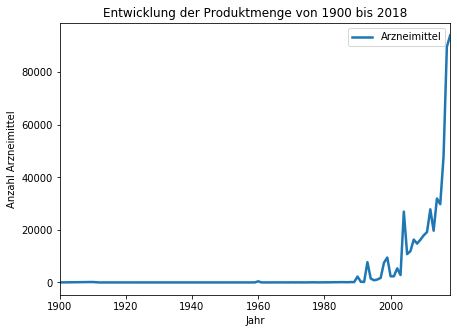

In [7]:
product_plot = product_eda.plot(linewidth=2.5, figsize=(7,5))
product_plot.set(ylabel='Anzahl Arzneimittel',
            xlabel='Jahr', title='Entwicklung der Produktmenge von 1900 bis 2018')

print(product_eda.describe())

In [18]:
# Anpassen des Datums bei ONMARKETDATE in product --> MySQL arbeitet mit amerikanischem Datumsformat
product['ONMARKETDATE'] = pd.to_datetime(product['ONMARKETDATE'], format='%d.%m.%Y')

product_eda_2 = product #eigenes DF für Analysezweck
product_eda_2['ONMARKETDATE'] = product_eda_2['ONMARKETDATE'].dt.month #Datum auf Jahr beschränken
#Nach Jahr gruppieren und aufsummieren
product_eda_2 = product_eda_2.groupby(product_eda_2['ONMARKETDATE'])['ID'].agg(['count']) 

In [19]:
product_eda_2.columns = ['Anzahl']
product_eda_2.reset_index()

,ONMARKETDATE,Anzahl
0,1,57112
1,2,35128
2,3,73129
3,4,45015
4,5,45712
5,6,39052
6,7,31708
7,8,27786
8,9,31729
9,10,112546


[Text(0, 0.5, 'Anzahl Arzneimittel'),
 Text(0.5, 0, 'Monat'),
 Text(0.5, 1.0, 'Aufsummierte Gesamtmenge an veröffentlichten Produkten pro Monat')]

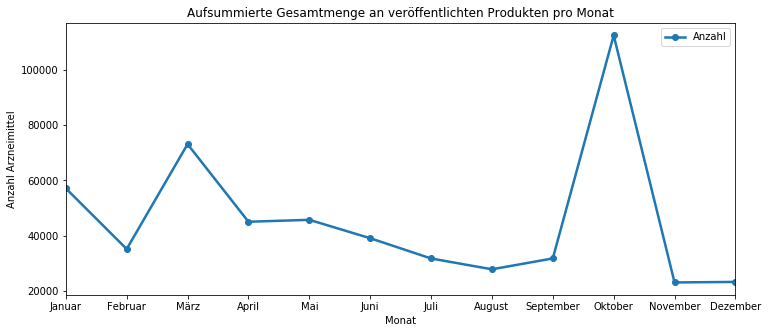

In [20]:
monate = ('Januar','Februar','März','April','Mai','Juni','Juli','August','September','Oktober','November','Dezember')
product_eda_2['Monat'] = monate
plot = product_eda_2.plot.line(y='Anzahl', x='Monat', linewidth=2.5, xticks=range(0, 12), figsize=(12,5), style='o-')

plot.set(ylabel='Anzahl Arzneimittel',
            xlabel='Monat', title='Aufsummierte Gesamtmenge an veröffentlichten Produkten pro Monat')

### Welche Arten von Produkten gibt es?

1. Untersuchung der Produktnamen anhand einer Wordcloud

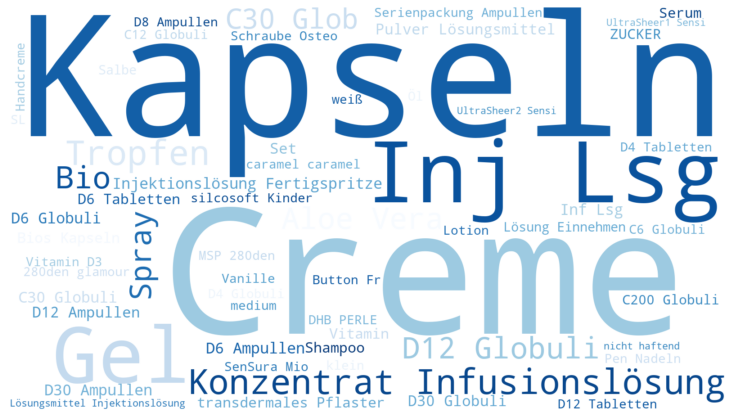

In [22]:
# 1. WordCloud
text = " ".join(word for word in product.NAME)

# Stopwords anlegen
stopwords = set(STOPWORDS)
stopwords.update(['mg','ml','einer','zur','Anwendung','mg','Einheit','Herstellung','Sp','sch','VTimp','HRW','schwarz',
                'subkutanen','forte','DHU','mediven','CCL1','CCL2','eleg','JUZO','BELSANA','comf','KKL2','Fuß',
                'COMPRESSANA','kurz','mit','AG','ohne','kompr','Gudjons','plus','SPIRIT','CCL3','LT','K2','groß',
                'AD','SP','K2','pet','SOFT','JOBST','NHB','medi','magenta','ELEG','DYNAMIC','K1','sensitiv','Hüftb',
                'K1','AGK','EHB','REG','SPITZE','laftofa','kkl','sigvaris','VenoTrain','balancehr','KL1','HRW','vet',
                'Spagyros','Dilution','SoSp','LM','SPRINg','NoB','pl','Fuss','Haftrand','Motiv','5cm','NoM','CL',
                'Wala','ku','MfB','MOTIV','BALANCEHAFTR','WEIT','Fo','la','OSP','GR','MAGIC','AGEK','TBs','BW','ca',
                'Staufen','LEGANZA','KL2','FINO','TBp','vg','TBe','TBb','6cm','KKL1','mv','SCHM','DHBM','Sp6','mode',
                'Maxis','Micro','CC Pharma','Micro CCL','DE LUXE','HbdNg','VTsof','BALANCEHAFTRAND','SCHMAL','Sp2',
                'DELUXE','CC','Pharma','Ecosana','Comfort','DE','LUXE','SPH','CHR','VENEX','DUR','ge','und','CCL',
                'duomed','basic','gFS','HbdNo','oFS','Lastofa','SHB','DYNAM','Suprima','gF','cm','NHBM','SSklFu',
                'Marine','klei','sw','oS','rose','amp','Sp4','HRMW','cara','VIOL','VENESSO','HBF','AGH','Venosan',
                'Inkontinenzhose','XXL','Kortikalis','GPH','Solus','cashmere','Sp3','K3','Sp7','LPS','HR','K2MS',
                'SILK','Mepilex','Opaque1','Noppe','Monofil','hrm','spagyra','ureterschiene','nova','haemato',
                'linea','blau','grün','rot','bronze','orange','gelb','mondscheinblau','pink','BB','Hauschka','AGKK',
                'Hyphen','fashy','Homeda','elegance','ho','Komplex','Roche','zum','sand','Anthroposan','black',
                'NHR','Junek','eco','TRACOE','Screw','anth','CCL2AT','anthrazit','XL','large','SILHB','m','Sp5',
                '2','1','o','M','Spitze','AT','5','3','Gr.','sigvaris','comfort','SIGVARIS','marine','Ccl2',
                'Rose','INSPIRATION','SCHWARZ','SENSITIV','SANDEL','PFEFFER','Ccl1','für','HAFTRAND','100','plus'])

# WordCloud generieren
wordcloud = WordCloud(
    max_words = 60,
    colormap = "Blues",
    width = 1600,
    height = 900,
    background_color = 'white',
    stopwords = stopwords).generate(str(text))

#Plotten
fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'w',
    edgecolor = 'w')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [18]:
# Frequenz der vorkommenden Wörter in Zahlen:
text_one = text.split()
text_two = list(stopwords)

text_final = [item for item in text_one if item not in text_two]

In [20]:
text_df = pd.DataFrame(text_final)
text_df.columns = ['Wort']

# Filtern auf Wörter, die mehr als drei Buchstaben aufweisen 
text_df = text_df[text_df['Wort'].map(len) > 2]

# Ausgabe der Frequenz jedes Wortes, sortiert nach absteigender Häufigkeit
print('Wortfrequenzen:')
pd.Series(' '.join(text_df['Wort']).split()).value_counts()[:10]

Wortfrequenzen:


Tabletten        6660
Globuli          6541
Filmtabletten    6359
Lösung           5492
MANDEL           4595
Ampullen         3833
MOHN             3761
steril           3468
SESAM            3364
Kapseln          3324
dtype: int64

### Weitere Werte:

In [13]:
print('Durchschn. Anzahl der Arzneimittel pro Jahr seit dem Jahr 2000:\n' + str(product_eda.tail(19).mean())) 
print('Marktwachstum im Mittel seit 2000:\n' + str(product_eda['Arzneimittel'].pct_change().tail(19).mean()))

Durchschn. Anzahl der Arzneimittel pro Jahr seit dem Jahr 2000:
Arzneimittel    25669.473684
dtype: float64
Marktwachstum im Mittel seit 2000:
0.5743037709546249


## Hersteller-Adresse

<b>Offene Fragen:</b>
1. In welchem Bundesland sind die Hersteller angesiedelt?
2. Aus welcher Stadt stammen die meisten Hersteller?
3. Wie sind die Unternehmen verteilt (Map-Ansicht Deutschland)
4. Wie viele Städte enthält der Datensatz?

Anzahl Hersteller in einer Stadt:
       Anzahl Hersteller
count        1973.000000
mean            2.177902
std             6.916063
min             1.000000
25%             1.000000
50%             1.000000
75%             2.000000
max           174.000000


,Anzahl Hersteller
CITY,
Berlin,174
München,159
Hamburg,143
Düsseldorf,66
Köln,62
Wien,45
Wiesbaden,25
Nürnberg,25
Essen,24


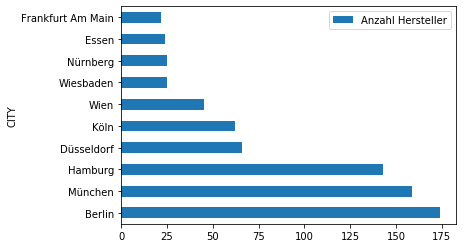

In [14]:
cmp_ad_eda = company_adress[['ID','CITY']] # eigenes DF für Analysezweck
cmp_ad_eda = cmp_ad_eda.groupby('CITY').count().sort_values(by='ID', ascending=False)
cmp_ad_eda.columns = ['Anzahl Hersteller'] # Umbenennen der Ergebnisspalte
print('Anzahl Hersteller in einer Stadt:')
print(cmp_ad_eda.describe())
cmp_ad_eda.head(10).plot.barh()
cmp_ad_eda.head(10)

In [15]:
# Datenpfad für Deutschland-Map mit PLZen
fp = "../data/maps/plz-gebiete.shp"
map_df = gpd.read_file(fp)

# Einlesen von PLZ-File
plz = pd.read_csv('../data/maps/plz-gebiete.csv', header=0, dtype={'plz': object})

# Merge von SHP-File und PLZ-File
merge_one = pd.concat([map_df, plz], axis=1)
# Überprüfen, ob Map geladen werden kann
merge_one.info()
print(merge_one.head(10))

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8706 entries, 0 to 8705
Data columns (total 2 columns):
geometry    8706 non-null object
plz         8706 non-null object
dtypes: object(2)
memory usage: 136.2+ KB
                                            geometry    plz
0  POLYGON ((5.8663153 51.0511035, 5.8669173 51.0...  52538
1  POLYGON ((5.9450447 51.823544, 5.9458032 51.82...  47559
2  POLYGON ((5.9681135 51.0555622, 5.969509 51.05...  52525
3  POLYGON ((5.9748624 50.7980367, 5.974951 50.79...  52074
4  POLYGON ((6.0150734 50.9478831, 6.0385415 50.9...  52531
5  POLYGON ((6.0150734 50.9478831, 6.0358606 50.9...  52511
6  POLYGON ((6.0159425 50.8387962, 6.0189456 50.8...  52072
7  POLYGON ((6.0260539 51.7086881, 6.0263358 51.7...  47574
8  POLYGON ((6.0368354 51.8440145, 6.0369576 51.8...  47533
9  POLYGON ((6.057427 50.8510367, 6.0587373 50.85...  52134


In [16]:
# DF für Städte mit der Postleitzahl
cmp_plz = company_adress[['ID', 'ZIP']]
cmp_plz = cmp_plz.groupby('ZIP').count().sort_values(by='ID', ascending=False) # Gruppieren nach PLZ
cmp_plz.columns = ['Anzahl'] # Umbenennung der Ergebnisspalte
cmp_plz = cmp_plz.reset_index()
cmp_plz.info()
cmp_plz.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2577 entries, 0 to 2576
Data columns (total 2 columns):
ZIP       2577 non-null object
Anzahl    2577 non-null int64
dtypes: int64(1), object(1)
memory usage: 40.4+ KB


,ZIP,Anzahl
0,40764,13
1,82152,12
2,82031,11
3,82041,11
4,82166,10


In [17]:
#Merge von Choropleth-Map und PLZ-DF
merge_two = pd.merge(merge_one, cmp_plz, left_on='plz', right_on='ZIP', how='left')
merge_two = merge_two.drop('ZIP', 1) # PlZ nach Merge doppelt enthalten --> Drop
merge_two = merge_two.fillna(0)
merge_two.Anzahl = merge_two.Anzahl.astype(int)
merge_two.head()

,geometry,plz,Anzahl
0,"POLYGON ((5.8663153 51.0511035, 5.8669173 51.0...",52538,2
1,"POLYGON ((5.9450447 51.823544, 5.9458032 51.82...",47559,0
2,"POLYGON ((5.9681135 51.0555622, 5.969509 51.05...",52525,2
3,"POLYGON ((5.9748624 50.7980367, 5.974951 50.79...",52074,1
4,"POLYGON ((6.0150734 50.9478831, 6.0385415 50.9...",52531,0


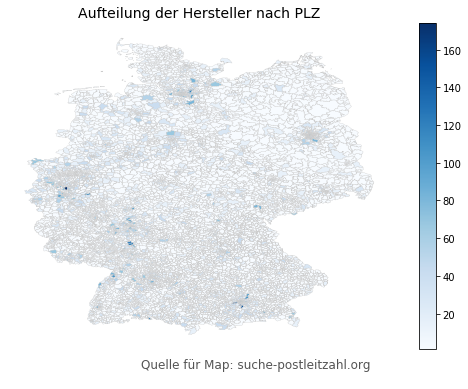

In [18]:
# Variable zur Festlegung der anzuzeigenden Spalte
variable = 'Anzahl'
# Range der Map
vmin, vmax = 1, 174
# Figur und Axen deklarieren
fig, ax = plt.subplots(1, figsize=(10, 6))

# Erstellen der Map
merge_two.plot(column=variable, cmap='Blues', linewidth=0.3, ax=ax, edgecolor='0.8')

# Titel
ax.set_title('Aufteilung der Hersteller nach PLZ', fontdict={'fontsize': '14', 'fontweight' : '2'})
# Annotation
ax.annotate('Quelle für Map: suche-postleitzahl.org',xy=(0.3, .08),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Axen ausblenden
ax.axis('off')

# Colorbar als Legende einfügen
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# Leeres Array für Daten-Range
sm._A = []
# Colorbar hinzufügen
cbar = fig.colorbar(sm)
fig.savefig('map_comp_plz', dpi=300)

In [19]:
# Datenpfad für Deutschland-Map mit 1stelliger PLZ
fp2 = "../data/maps/GermanyPolygon21.shp"
map2_df = gpd.read_file(fp2)

# Einlesen von Bundesland-File
states = pd.read_csv('../data/maps/states.csv', header=0)
states.info()

# Merge von SHP-File und PLZ-File
merge_three = pd.concat([map2_df, states], axis=1)
merge_three.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 1 columns):
Bundesland    16 non-null object
dtypes: object(1)
memory usage: 256.0+ bytes


,geometry,Bundesland
0,"(POLYGON ((9.004728999999999 47.7217414, 9.004...",Baden-Wuerttemberg
1,"POLYGON ((8.9763497 50.0497851, 8.976374 50.05...",Bayern
2,"(POLYGON ((13.08835 52.41964, 13.0958394 52.42...",Berlin
3,"(POLYGON ((11.2676118 53.1219715, 11.2693117 5...",Brandenburg
4,"(POLYGON ((8.732263700000001 53.1139601, 8.733...",Bremen


In [20]:
# Einlesen von Zuordnungstabelle von PLZ zu Bundesländern
zip_to_states = pd.read_csv('../data/maps/zip_to_states.csv', header=0, sep=';', dtype={'PLZ': object})

# Neues DF für diese Analyse aus ID und PLZ der Hersteller-Adresse-Tabelle
cmp_eda2 = company_adress[['ID', 'ZIP']]

# Merge von Hersteller-Adresse und Bundesland
merge_four = pd.merge(cmp_eda2, zip_to_states, left_on="ZIP", right_on="PLZ")
merge_four = merge_four.drop(['ZIP', 'PLZ'], axis=1) # PLZen werden nicht weiter benötigt

# Count für die Bundesländer
merge_four = merge_four.groupby('Bundesland').count().sort_values(by='ID', ascending=False) # Gruppieren nach PLZ
merge_four.columns = ['Anzahl'] # Umbenennung der Ergebnisspalte
merge_four = merge_four.reset_index()
merge_four

,Bundesland,Anzahl
0,Bayern,798
1,Nordrhein-Westfalen,761
2,Baden-Wuerttemberg,509
3,Hessen,391
4,Niedersachsen,252
5,Berlin,181
6,Schleswig-Holstein,169
7,Hamburg,151
8,Rheinland-Pfalz,148
9,Saarland,61


In [21]:
#Merge von Choropleth-Map und Bundesland-DF
merge_five = pd.merge(merge_three, merge_four, left_on='Bundesland', right_on='Bundesland', how='left')
merge_five = merge_five.drop('Bundesland', 1) # PlZ nach Merge doppelt enthalten --> Drop
merge_five.Anzahl = merge_five.Anzahl.astype(int)
print(merge_five.describe())
merge_five.head()

           Anzahl
count   16.000000
mean   223.812500
std    258.872226
min      8.000000
25%     35.000000
50%    149.500000
75%    286.750000
max    798.000000


,geometry,Anzahl
0,"(POLYGON ((9.004728999999999 47.7217414, 9.004...",509
1,"POLYGON ((8.9763497 50.0497851, 8.976374 50.05...",798
2,"(POLYGON ((13.08835 52.41964, 13.0958394 52.42...",181
3,"(POLYGON ((11.2676118 53.1219715, 11.2693117 5...",52
4,"(POLYGON ((8.732263700000001 53.1139601, 8.733...",17


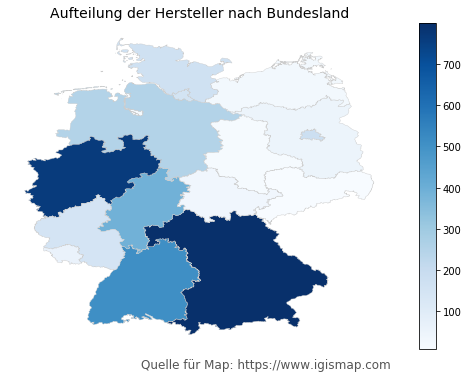

In [22]:
# Variable zur Festlegung der anzuzeigenden Spalte
variable2 = 'Anzahl'
# Range
vmin, vmax = 8, 798
# Figure anlegen
fig, ax = plt.subplots(1, figsize=(10, 6))

# Erstellen der Map
merge_five.plot(column=variable, cmap='Blues', linewidth=0.4, ax=ax, edgecolor='0.8')

# Titel
ax.set_title('Aufteilung der Hersteller nach Bundesland', fontdict={'fontsize': '14', 'fontweight' : '2'})
# Annotation
ax.annotate('Quelle für Map: https://www.igismap.com',xy=(0.3, .08),  xycoords='figure fraction', 
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

# Axen ausblenden
ax.axis('off')

# Colorbar als Legende einfügen
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
# Leeres Array für die Daten-Range
sm._A = []
# Colobar
cbar = fig.colorbar(sm)

# Speichern der Grafik
fig.savefig("map_comp_states.png", dpi=300)

## Produkt-Hersteller
<b>Offene Fragen:</b>
1. Welcher Hersteller stellt die meisten Arzneimittel her?
2. Wie viele Arzneimittel hat ein Hersteller im Durchschnitt auf dem Markt?
3. Gibt es Hersteller, die kaum noch aktiv sind? (Kombination aus Markteintrittsdatum und Hersteller)

In [610]:
# Merge aus den Produkten und Herstellern
prod_comp_merge = pd.merge(product, product_company, left_on='ID', right_on='PRODUCTID')
prod_comp_merge = prod_comp_merge.drop('PRODUCTID', 1) # PRODUCTID nach Merge doppelt enthalten --> Drop
# Hersteller dem jeweiligen Produkt zuweisen
prod_comp_merge2 = pd.merge(prod_comp_merge, company[['ID','NAME']], left_on="COMPANYID", right_on="ID")
prod_comp_merge2 = prod_comp_merge2[['ID_x','NAME_x','ONMARKETDATE','NAME_y']] # Doppelte Spalten entfernen
prod_comp_merge2.columns = ['ID','Arzneimittel','Markteintrittsdatum','Hersteller'] #Spaltenumbenennung
prod_comp_merge2 = prod_comp_merge2.sort_values(by='ID', ascending=True) # Sortierung nach ID aufsteigend

In [611]:
prod_comp_merge2.head()

,ID,Arzneimittel,Markteintrittsdatum,Hersteller
0,14,"Trental® 400 mg, Retardtabletten",1977,Sanofi-Aventis Deutschland GmbH
401,21,BETOPTIMA® 5 mg/ml Augentropfen,1985,Novartis Pharma GmbH
659,30,Cyclopentolat Alcon® 1% Augentropfen,1998,Alcon Pharma GmbH
402,32,DEXA-SINE® 1 mg/ml Augentropfen,1998,Novartis Pharma GmbH
403,33,"DEXA-SINE® SE 1,315 mg/ml Augentropfen",1989,Novartis Pharma GmbH


             Anzahl
count   4316.000000
mean     126.368628
std     1466.241473
min        1.000000
25%        3.000000
50%       10.000000
75%       41.000000
max    53674.000000
                                                    Anzahl
Hersteller                                                
Medi GmbH & Co. KG                                   53674
Julius Zorn GmbH                                     52317
ARCANA Dr. Sewerin GmbH & Co. KG Arzneimittel-H...   48452
Compressana GmbH                                     17841
Belsana Medizinische Erzeugnisse Zweigniederlas...   16622
Bauerfeind AG Geschäftsbereich Phlebologie           12851
Bsn-Jobst GmbH                                       11286
DHU-Arzneimittel GmbH & Co. KG                        9732
Sigvaris GmbH                                         6755
Gudjons GmbH                                          5110


[Text(0, 0.5, ''),
 Text(0.5, 1.0, 'Die zehn größten Hersteller von Arzneimitteln')]

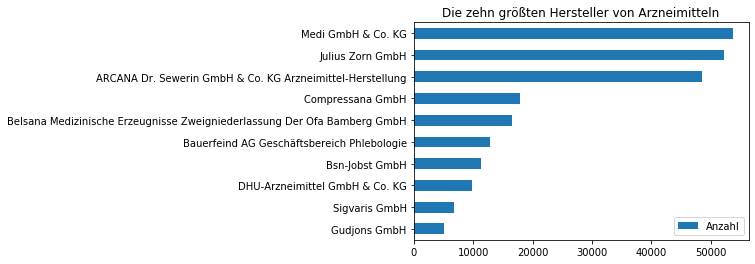

In [513]:
prod_comp_merge3 = prod_comp_merge2[['ID','Hersteller']]
prod_comp_merge3 = prod_comp_merge3.groupby('Hersteller').count().sort_values(by='ID', ascending=False)
prod_comp_merge3.columns = ['Anzahl'] # Umbenennung der Ergebnisspalte
print(prod_comp_merge3.describe())
print(prod_comp_merge3.head(10))
plot = prod_comp_merge3.head(10).sort_values(by='Anzahl').plot.barh()
plot.set(title='Die zehn größten Hersteller von Arzneimitteln',
        ylabel='')

Anzahl der Hersteller die nur wenige Produkte herstellen:

In [615]:
prod_comp_merge3.head(10)

,Anzahl
Hersteller,
Medi GmbH & Co. KG,53674
Julius Zorn GmbH,52317
ARCANA Dr. Sewerin GmbH & Co. KG Arzneimittel-Herstellung,48452
Compressana GmbH,17841
Belsana Medizinische Erzeugnisse Zweigniederlassung Der Ofa Bamberg GmbH,16622
Bauerfeind AG Geschäftsbereich Phlebologie,12851
Bsn-Jobst GmbH,11286
DHU-Arzneimittel GmbH & Co. KG,9732
Sigvaris GmbH,6755


## Interaktionen
<b>Offene Fragen:</b>
1. Welche Wirkstoffe generieren am häufigsten Wechselwirkungen?
2. Weche Wirkstoffe generieren am wenigsten Wechselwirkungen?
3. Schweregradanalyse (Was kommt am häufigsten vor, was selten etc.)
4. Analyse des Untersuchungsgrads 

In [22]:
# Anlegen eines DF eigens für diese Untersuchung
interaction_eda = interaction
# Head anzeigen
interaction_eda.head()

,INTERACTIONCLASSID1,INTERACTIONCLASSID2,SEVERITYID,SEVERITY,LIKELIHOODID,LIKELIHOOD,PRECAUTION,NOTES,REFERENCE,FORWARDOBSERVATIONID,...,FILL42,FILL43,FILL44,FILL45,FILL46,FILL47,FILL48,FILL49,FILL50,FILL51
0,1,12317,2,mittelschwer,3,Begrenzt untersucht.,Kombination mit Vorsicht anwenden.\nAuf potenz...,Orale Ascorbinsäure kann die Aluminiumresorpti...,<ul><li><b>Aluminium hydroxide + Ascorbic acid...,06/05/2011,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4,450,2,mittelschwer,3,Begrenzt untersucht.,Auf potenzielle Anzeichen einer Interaktion mi...,Folsäure und ihre Derivate können die Toxizitä...,"<ul><li><b>Cassidy J, Dirix L, Bissett D et al...",20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,10205,3,geringfügig,4,Nicht erwiesen,Kombination mit Vorsicht anwenden.\nHämatologi...,Die gleichzeitige Gabe von Folsäure und Chlora...,<ul><li><b>Folic Acid</b>; American Hospital F...,17/11/2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,148,4,Vorsicht,3,Begrenzt untersucht.,Kombination mit Vorsicht anwenden.,"Substanzen, die den Urin deutlich ansäuern, so...","<ul><li><b>Johnston A, Burgess CD, Warrington ...",7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,190,4,Vorsicht,3,Begrenzt untersucht.,Kein Handlungsbedarf; aber auf potenzielle Int...,Harnansäuernde Mittel vermindern die renale Au...,<ul><li><b>Salicylates</b>; Drug Facts and Com...,07/08/2008,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ausprägung der Spalten SEVERITY und LIKELIHOOD

Ergebnis: 
- Jede der Spalten beinhaltet vier einzigartige Ausprägungsmöglichkeiten
- Der Schwierigkeitsgrad 'mittelschwer' kommt am Häufigsten vor (in 4325 von 7619 Fällen - 57 %)
- Die Wahrscheinlichkeit 'Begrenz untersucht' kommt am Häufigsten vor (in 2973 von 7619 Fällen - 39 %)

count             7619
unique               4
top       mittelschwer
freq              4325
Name: SEVERITY, dtype: object
----
count                     7619
unique                       4
top       Begrenzt untersucht.
freq                      2973
Name: LIKELIHOOD, dtype: object


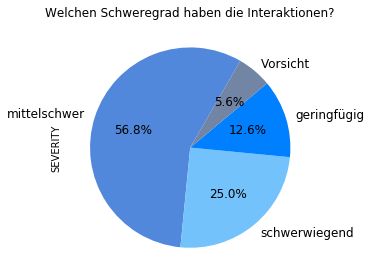

In [23]:
print(str(interaction_eda.SEVERITY.describe()) + '\n' + '----'+ '\n'+ str(interaction_eda.LIKELIHOOD.describe()))

# Grafische Veranschaulichung
interaction_eda.SEVERITY.value_counts().plot.pie(
    startangle=60,
    autopct='%1.1f%%',
    fontsize=12,
    title='Welchen Schweregrad haben die Interaktionen?',
    colors=('#5288DB', '#73C2FB','#0080FF','#7285A5'))
plt.tight_layout()
plt.show()

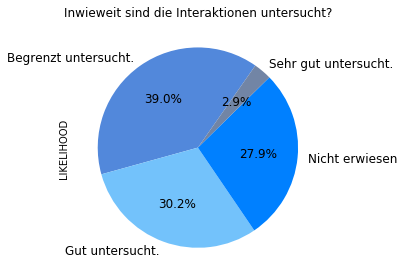

In [24]:
interaction_eda.LIKELIHOOD.value_counts().plot.pie(
    startangle=55,
    autopct='%1.1f%%',
    fontsize=12,
    title='Inwieweit sind die Interaktionen untersucht?',
    colors=('#5288DB', '#73C2FB','#0080FF','#7285A5'))
plt.tight_layout()
plt.show()

Interessant ist zudem, wie gut die jeweils einzelnen Interaktionenstypen untersucht sind.

Ergebnis:
- Die schwerwiegenden und mittelschweren Interaktionen sind größtenteils nur begrenzt untersucht oder gar nicht erwiesen.
- Generell sind die wenigstens Interaktionen überhaupt sehr gut untersucht.

In [25]:
interaction_eda_2 = interaction_eda.groupby(['SEVERITY','LIKELIHOOD']).count()['INTERACTIONCLASSID1'].unstack()
interaction_eda_2.head()

LIKELIHOOD,Begrenzt untersucht.,Gut untersucht.,Nicht erwiesen,Sehr gut untersucht.
SEVERITY,,,,
Vorsicht,240,35,146,5
geringfügig,410,414,119,17
mittelschwer,1912,1370,933,110
schwerwiegend,411,483,924,90


/Users/markushemmer/PycharmProjects/firstdjango/myvenv/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:203: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  "'colors' is being deprecated. Please use 'color'"


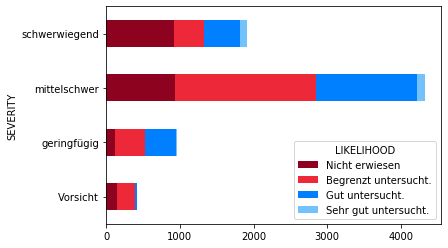

In [26]:
interaction_eda_2 = interaction_eda_2[['Nicht erwiesen','Begrenzt untersucht.','Gut untersucht.','Sehr gut untersucht.']]
interaction_eda_2.head()

interaction_eda_2.plot.barh(stacked=True,
                           color=('#8D021F', '#ED2939','#0080FF','#73C2FB') )

#### Welche Interaktionsklassen weißen am meisten Wechselwirkungen auf und welche Interaktionsklassen sind am häufigsten schwerwiegend oder mittelschwer?

Prequisite: Merge aus Interaktionsklassen und Interaktionen, um die Namen der Interaktionsklassen aufzeigen zu können.

In [27]:
# Merge aus Interaktionsklassen und Interaktionen
interaction_eda_3 = pd.merge(interaction, interaction_class, left_on='INTERACTIONCLASSID1',
    right_on='INTERACTIONCLASSID')

interaction_eda_4 = interaction_eda_3.groupby('NAME').count()['INTERACTIONCLASSID2']
interaction_eda_4 = interaction_eda_4.to_frame()
interaction_eda_4.columns = ['Anzahl Interaktionen']

# Wie viele Interaktionen weist eine Interaktionsklasse im Schnitt auf?
interaction_eda_4.describe()

,Anzahl Interaktionen
count,1227.000000
mean,6.209454
std,9.046155
min,1.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,105.000000


#### Welche Interaktionsklassen haben/verursachen die meisten Wechselwirkungen?

In [28]:
interaction_eda_4 = interaction_eda_4.reset_index()
interaction_eda_4.columns = ['Wirkstoff', 'Anzahl Interaktionen']
interaction_eda_4.sort_values(ascending=False, by='Anzahl Interaktionen').tail(10)

,Wirkstoff,Anzahl Interaktionen
917,Prochlorperazin,1
450,Etomidat,1
461,Fenofibrat,1
463,Fenyramidol,1
468,Finasterid,1
907,Prilocain,1
474,Flucytosin,1
905,Prednison,1
480,Fluphenazin (und Salze),1
1226,Östrogene (systemisch),1


#### In welchen Schweregrad-Klassen sind welche Wirkstoffe besonders dominant?

In [606]:
interaction_eda_3.head()
interaction_eda_5 = interaction_eda_3[['SEVERITY','INTERACTIONCLASSID2', 'LIKELIHOOD','NAME']]

kategorienliste = ('schwerwiegend', 'mittelschwer', 'geringfügig', 'Vorsicht')

# For-Schleife, um jede Kategorie zu durchlaufen
for kategorie in kategorienliste:
    print(interaction_eda_5[interaction_eda_5.SEVERITY == kategorie].groupby(['SEVERITY',
            'NAME']).size().sort_values(ascending=False).head())

SEVERITY       NAME       
schwerwiegend  Dronedaron     43
               Domperidon     41
               Ajmalin        38
               Lumefantrin    38
               Ondansetron    35
dtype: int64
SEVERITY      NAME                                
mittelschwer  Phenytoin und verwandte Verbindungen    93
              Carbamazepin                            50
              Ciclosporin                             42
              Hydroxychloroquin                       39
              Crizotinib                              36
dtype: int64
SEVERITY     NAME                                  
geringfügig  Starke CYP3A4-Hemmer (außer Ritonavir)    15
             Carbamazepin                              10
             Cimetidin                                 10
             Insulin                                    9
             Atorvastatin                               9
dtype: int64
SEVERITY  NAME                                       
Vorsicht  Selektive Alpha-2-Rezeptor-

## Produkt-Interaktion

Dieses DF gibt alle Produkte und deren im Zusammenhang mit einer Interaktion stehenden Wirkstoffe an.

<b>Offene Fragen:</b>
1. Welches Produkt hat am meisten Interaktionsklassen
2. Durchschnittliche Anzahl von Interaktionsklassen pro Produkt
3. Welche Interaktionsklasse hat am meisten Verknüpfungen zu Produkten
4. Welche Produkte sind am gefährlichsten? (Aufbauend auf der Analyse der gefährlichsten Wirkstoffe)

#### Produkt mit den meisten Interaktionsklassen (meisten enthaltenen Wirkstoffe, die eine Interaktion verursachen können)

Zunächst muss das Produkt-Interaktionen-DF mit dem Produkt DF gemerged werden:

In [334]:
# Merge aus Produkt-Interaktionen und Produkten
prod_inter_eda = pd.merge(product_interaction_class, product, left_on='PRODUCTID',
    right_on='ID')

# Für die Analyse ausreichend sind die Interaktionsklasse und der Name des Produkts
prod_inter_eda1 = prod_inter_eda[['INTERACTIONCLASSID','NAME']]

prod_inter_eda1 = prod_inter_eda1.groupby(['NAME']).count().sort_values(by='INTERACTIONCLASSID', 
                                                                        ascending=False).reset_index()
prod_inter_eda1.columns = ['Arzneimittel', 'Anzahl'] # Umbenennung der Ergebnisspalte
prod_inter_eda1.head(10)

,Arzneimittel,Anzahl
0,"Olimel 4,4 % E Emulsion zur Infusion, 2000 ml ...",29
1,"Olimel 5,7 % E Emulsion zur Infusion, 2000 ml ...",29
2,"Olimel 5,7 % E Emulsion zur Infusion, 1500 ml ...",29
3,"Olimel 5,7 % E Emulsion zur Infusion, 1000 ml ...",29
4,"Olimel 4,4 % E Emulsion zur Infusion, 1500 ml ...",29
5,"Olimel 4,4 % E Emulsion zur Infusion, 1000 ml ...",29
6,Arelix® ACE 5 mg/6 mg Tabletten,24
7,Cernevit + Addel Trace (Mikronährstoff-Set) Ko...,23
8,"Irbesartan HCTZ Fair-Med 150+12,5 mg Filmtable...",20
9,"Irbesartan HCTZ Fair-Med 300+12,5 mg Filmtable...",20


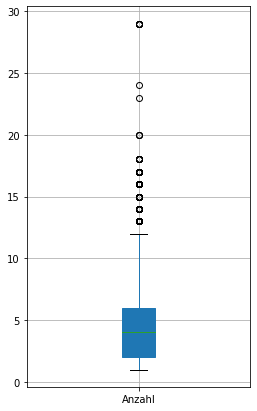

In [292]:
# Darstellung der Verteilung als Boxplot
prod_inter_eda1.boxplot(patch_artist=True,figsize=(4,7))

In [293]:
# Tabellarische Darstellung
prod_inter_eda1.describe()

,Anzahl
count,32663.000000
mean,4.370235
std,2.707902
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,29.000000


Ergebnis 1: 
 - Die meisten Interaktionsklassen beinhaltet das Produkt Olimel 5,7 % E Emulsion zur Infusion
 - Boxplot zeigt Verteilungen
 - Im Durchschnitt beinhalten Medikamente, die Interaktionen herbeiführen, rund vier Wirkstoffe
 - Maximum bei 29
 - 25%-Quantil bei 2, Median bei 4, 75%-Quantil bei 6

#### Welche Interaktionsklassen/Wirkstoffe tauchen am häufigsten in den Produkten auf?

Merge aus Interaktionsklasse und Produkt-Interaktion DF

In [341]:
# Merge aus Interaktionsklassen und Produkt-Interaktion
prod_inter_eda2 = pd.merge(product_interaction_class, interaction_class, left_on='INTERACTIONCLASSID',
                          right_on='INTERACTIONCLASSID')
prod_inter_eda2.columns = ['INTERACTIONCLASSID','Arzneimittel','Interaktionsklasse'] # Umbenennung der Spalten
prod_inter_eda2 = prod_inter_eda2[['Arzneimittel', 'Interaktionsklasse']]

prod_inter_eda2 = prod_inter_eda2.groupby(['Interaktionsklasse']).count().sort_values(by="Arzneimittel",
                                                                                      ascending=False)
prod_inter_eda2.columns = ['Anzahl'] # Umbenennung der Ergebnisspalte
prod_inter_eda2.reset_index().head(10)

,Interaktionsklasse,Anzahl
0,Oral verabreichte Arzneimittel,23030
1,"Arzneimittel, Bradykinin und Angioödem",4370
2,Arzneimittel zur Senkung des arteriellen Blutd...,3030
3,Sedativa,2996
4,Substanzen mit Risiko für CYP3A4,2450
5,Kaliumsenkende Arzneimittel,1923
6,Antipsychotika,1609
7,Angiotensin II Antagonisten,1497
8,Angiotensin-II-Rezeptor-Antagonisten,1497
9,Antipsychotische Neuroleptika (außer Clozapin),1449


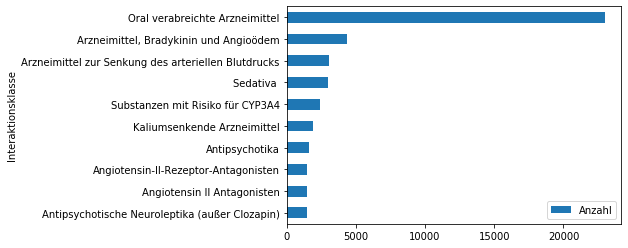

In [338]:
# Darstellung in Form eines Balkendiagramms
prod_inter_eda2.head(10).sort_values(by="Anzahl", ascending=True).plot.barh()

Oral verabreichte Arzneimittel zählt eindeutig als Ausreißer und wird für die Darstellung eines Boxplos ausgeblendet

In [329]:
# Zusammenfassung der Auswertung
prod_inter_eda2.reset_index().describe()

,Anzahl
count,1161.000000
mean,122.950043
std,724.363670
min,1.000000
25%,8.000000
50%,28.000000
75%,89.000000
max,23030.000000


Ergebnis 2: 
- Sehr interessante Darstellung, da hierbei auffällt, dass es sehr viele Wirkstoffgruppen gibt. Außerdem liefern diese sogar weitere Informationen wie z.B. die Art und Weise der Einnahme oder die genaue Funktion/Wirkungen des Präparats.

#### Wie viele Medikamente aus dem Gesamtdatensatz erzeugen überhaupt Wechselwirkungen?

Das Produkt-Interaktion DataFrame hat deutlich weniger Zeilen als das Produkt-DF. Ein Großteil der Medikamente erzeugt also gar keine Wechselwirkungen! Dies gilt es zu untersuchen.

Es muss die Anzahl der einzelnen Produkte im Produkt-Interaktion DF mit der Anzahl aller Produkte verglichen werden.

In [285]:
# Ausgabe der Anzahl für Produkte ohne und mit bekannten Interaktionen
count_prod_inter = product_interaction_class.PRODUCTID.nunique()
count_prod = product.ID.count() - count_prod_inter # Abzgl. der Interaktions-Produkte, sonst doppelt enthalten

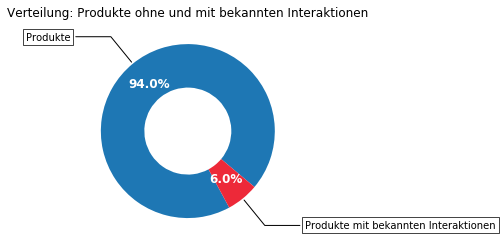

In [287]:
# Darstellung in Form eines Kreisdiagramms

fig, ax = plt.subplots(figsize=(8, 4), subplot_kw=dict(aspect="equal"))

labels = 'Produkte', 'Produkte mit bekannten Interaktionen'
sizes = [count_prod, count_prod_inter]

wedges, texts, autotexts = ax.pie(sizes, wedgeprops=dict(width=0.5), startangle=-40, colors=('#1e77b4', '#ED2939'),
                                autopct='%1.1f%%', pctdistance=0.7)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)

ax.set_title("Verteilung: Produkte ohne und mit bekannten Interaktionen")
plt.setp(autotexts, size=12, weight="bold", color='w')

plt.show()